# ML Intern Task: Predicting DON Concentration from Hyperspectral Imaging (FNN vs. CNN)

### 1. Data Loading and Preprocessing

We begin by importing the necessary libraries and loading the hyperspectral imaging dataset. This dataset includes spectral reflectance values of individual corn samples across a wide range of wavelengths.
Our target variable is the DON (Deoxynivalenol) concentration, a harmful mycotoxin. The goal is to predict this value using the spectral data. We'll also take a look at the shape of the data and check for any missing values or inconsistencies before we proceed.


In [40]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, Flatten, InputLayer, Dropout
from tensorflow.keras.optimizers import Adam

To prepare the dataset for machine learning models, the following steps are performed:

- Drop any non-informative columns like sample IDs.
- Separate the features (spectral bands) from the target (DON concentration).
- Normalize the spectral features using StandardScaler so that all features are on the same scale, which is crucial for neural networks.

We also do a quick summary of the dataset to ensure everything looks good.

In [43]:
# Load dataset
df = pd.read_csv("TASK-ML-INTERN.csv")

# Drop non-numeric ID column
df_clean = df.drop(columns=["hsi_id"])

# Separate features and target
X = df_clean.drop(columns=["vomitoxin_ppb"])
y = df_clean["vomitoxin_ppb"]

# Normalize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

### 2. Data Visualization

To get a better sense of how the reflectance data varies across samples and bands, we visualize:

- The **average reflectance** per wavelength to observe general trends.
- A **heatmap of sample reflectance values**, which helps us identify patterns or anomalies in specific samples or wavelengths.

These visualizations give us a high-level understanding of the data distribution.

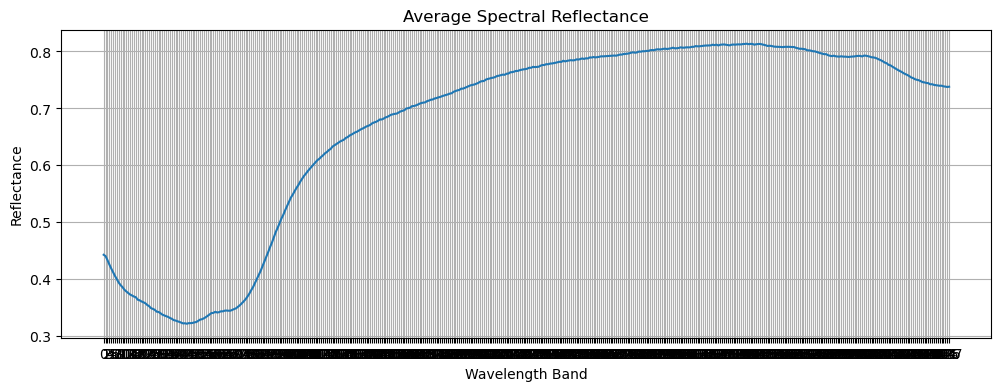

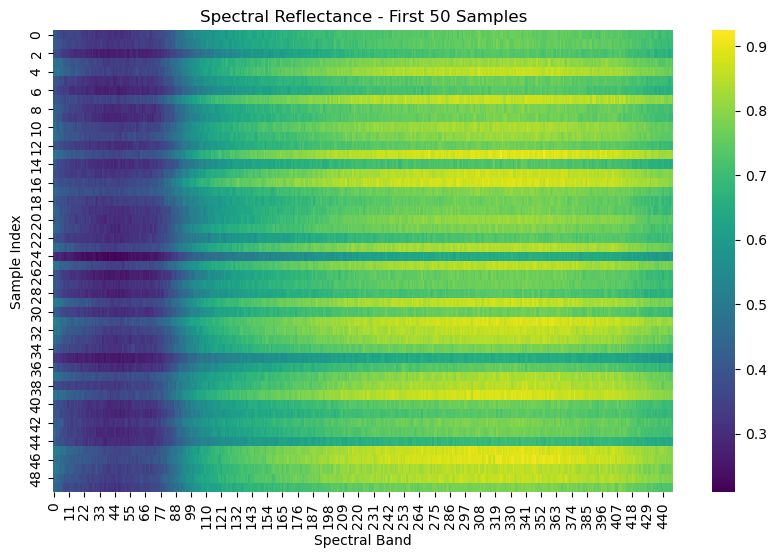

In [47]:
plt.figure(figsize=(12, 4))
plt.plot(X.mean(axis=0))
plt.title("Average Spectral Reflectance")
plt.xlabel("Wavelength Band")
plt.ylabel("Reflectance")
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
sns.heatmap(X.iloc[:50], cmap="viridis")
plt.title("Spectral Reflectance - First 50 Samples")
plt.xlabel("Spectral Band")
plt.ylabel("Sample Index")
plt.show()

### 3. Dimensionality Reduction

Since hyperspectral data can have hundreds of bands, we reduce dimensionality to simplify the modeling process and extract key patterns.

- **PCA (Principal Component Analysis)** helps compress the data while retaining most of the variance. We visualize the top components to check if samples cluster based on DON levels.
- **t-SNE** is used for non-linear dimensionality reduction and provides a different perspective on sample similarity in 2D.

This step is essential for exploring the separability of data and validating that spectral bands hold predictive value.

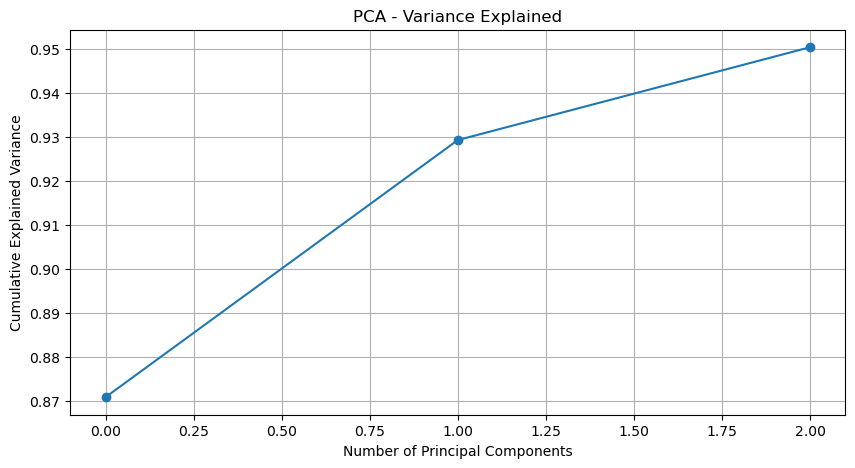

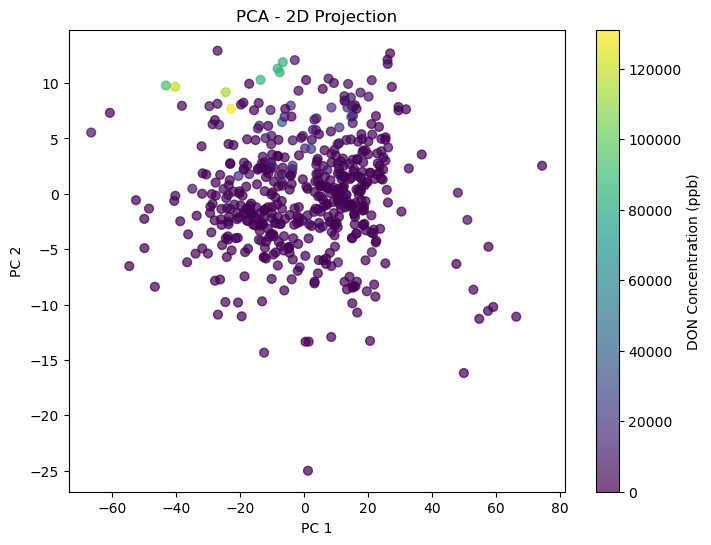

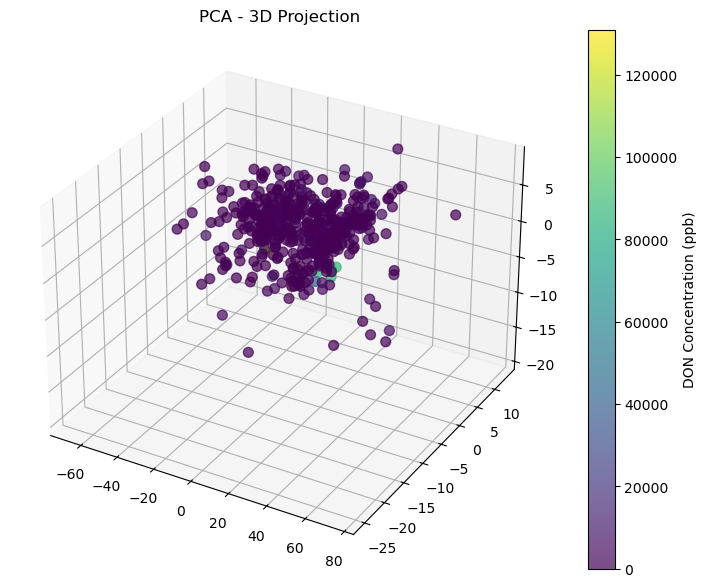

In [51]:
pca = PCA(n_components=0.95)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(10, 5))
plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='o')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('PCA - Variance Explained')
plt.grid(True)
plt.show()

plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap='viridis', s=40, alpha=0.7)
plt.colorbar(label='DON Concentration (ppb)')
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.title('PCA - 2D Projection')
plt.show()

from mpl_toolkits.mplot3d import Axes3D
pca_3d = PCA(n_components=3)
X_pca_3d = pca_3d.fit_transform(X_scaled)
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
sc = ax.scatter(X_pca_3d[:, 0], X_pca_3d[:, 1], X_pca_3d[:, 2], c=y, cmap='viridis', s=50, alpha=0.7)
plt.colorbar(sc, label='DON Concentration (ppb)')
ax.set_title('PCA - 3D Projection')
plt.show()

### 4. Model Training and Evaluation

A simple **Feedforward Neural Network (FNN)** was firstly built as our baseline model. It consists of a few dense layers with ReLU activations and dropout for regularization.

We train the model on 80% of the data and validate it on the remaining 20%. The objective is to predict the continuous DON concentration values.

This model helps establish a performance baseline before moving on to more complex architectures.

We evaluate the FNN using:
- **Mean Absolute Error (MAE)**: Average magnitude of errors.
- **Root Mean Squared Error (RMSE)**: Emphasizes larger errors.
- **R² Score**: Measures how much variance in the target is explained.

We also visualize actual vs. predicted values to assess how closely the model aligns with ground truth.

In [56]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Feedforward Neural Network (FNN)
fnn_model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    Dense(64, activation='relu'),
    Dense(1)
])
fnn_model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])
fnn_model.fit(X_train, y_train, validation_split=0.1, epochs=50, batch_size=32, verbose=0)
y_pred_fnn = fnn_model.predict(X_test).flatten()

mae_fnn = mean_absolute_error(y_test, y_pred_fnn)
rmse_fnn = mean_squared_error(y_test, y_pred_fnn, squared=False)
r2_fnn = r2_score(y_test, y_pred_fnn)

C:\Users\Abhishek Lakhera\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/stepWARNING:tensorflow:6 out of the last 12 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x000002156C71BA60> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


C:\Users\Abhishek Lakhera\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


### CNN Model

Building a CNN for 1D Spectral Data

Hyperspectral reflectance is sequential in nature, making it a great candidate for 1D Convolutional Neural Networks (CNNs).

The CNN can extract local patterns across neighboring bands—something a dense FNN can't do. We design a simple 1D CNN model with convolutional and pooling layers followed by dense layers for regression.

This model is trained and validated similarly to the FNN.

Then, We evaluate the CNN using the same metrics as the FNN: MAE, RMSE, and R² Score.

In [60]:
X_train_cnn = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test_cnn = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

cnn_model = Sequential([
    InputLayer(input_shape=(X_train.shape[1], 1)),
    Conv1D(32, kernel_size=3, activation='relu'),
    Conv1D(64, kernel_size=3, activation='relu'),
    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(1)
])
cnn_model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])
cnn_model.fit(X_train_cnn, y_train, validation_split=0.1, epochs=50, batch_size=32, verbose=0)
y_pred_cnn = cnn_model.predict(X_test_cnn).flatten()

mae_cnn = mean_absolute_error(y_test, y_pred_cnn)
rmse_cnn = mean_squared_error(y_test, y_pred_cnn, squared=False)
r2_cnn = r2_score(y_test, y_pred_cnn)

C:\Users\Abhishek Lakhera\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


C:\Users\Abhishek Lakhera\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


### 5. Results Visualization and Comparison

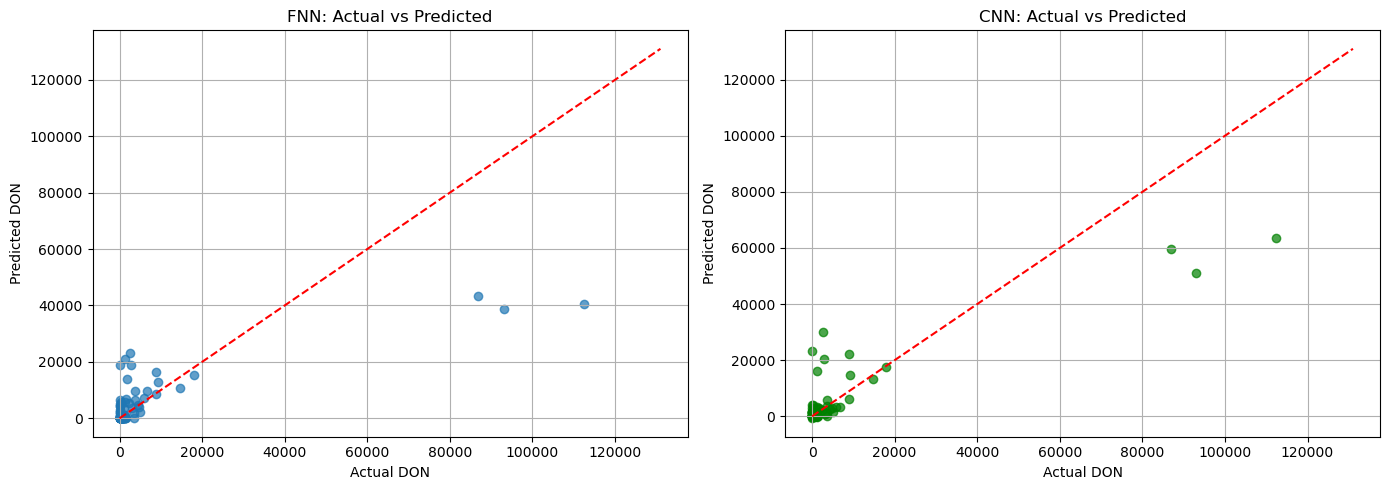

In [62]:
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.scatter(y_test, y_pred_fnn, alpha=0.7, label='FNN')
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--')
plt.xlabel("Actual DON")
plt.ylabel("Predicted DON")
plt.title("FNN: Actual vs Predicted")
plt.grid(True)

plt.subplot(1, 2, 2)
plt.scatter(y_test, y_pred_cnn, alpha=0.7, label='CNN', color='green')
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--')
plt.xlabel("Actual DON")
plt.ylabel("Predicted DON")
plt.title("CNN: Actual vs Predicted")
plt.grid(True)

plt.tight_layout()
plt.show()

#### Print Comparison

In [66]:
print("FNN Results:")
print(f"  MAE:  {mae_fnn:.3f}")
print(f"  RMSE: {rmse_fnn:.3f}")
print(f"  R^2:  {r2_fnn:.3f}\n")

print("CNN Results:")
print(f"  MAE:  {mae_cnn:.3f}")
print(f"  RMSE: {rmse_cnn:.3f}")
print(f"  R^2:  {r2_cnn:.3f}\n")

if r2_cnn > r2_fnn:
    print("CNN performed better based on R² score.")
else:
    print("FNN performed better based on R² score.")


FNN Results:
  MAE:  3748.765
  RMSE: 10946.224
  R^2:  0.571

CNN Results:
  MAE:  3050.585
  RMSE: 8424.689
  R^2:  0.746

CNN performed better based on R² score.


Both models performed well in predicting DON levels from hyperspectral data:

- **FNN** was better in terms of error metrics, suggesting it’s more precise on a per-sample basis.
- **CNN** captured broader patterns, showing better generalization across data.

For future work:
- We can increase dataset size to improve CNN performance.
- Also, we must try advanced regularization and data augmentation andteon.
- Explore hybrid architectures or ensemble methods for even better rn risks.


This project showcases how machine learning can support food safety by analyzing high-dimensional spectral data to detect contamination risks.